## Only run this on google colab.

In [34]:
!cd robocar-lane-segmentation

/bin/sh: 1: cd: can't cd to robocar-lane-segmentation


In [2]:
%load_ext autoreload
%autoreload 2

import os
import math
os.sys.path += ['slim']

import tensorflow as tf
import slim.nets.mobilenet.mobilenet_v2 as mobilenet_v2
import numpy as np
import matplotlib.pyplot as plt

from my_dataset import MyDataset
from model import mobilenet_backbone, load_mobilenet_weights, segmentation_head


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Option 1: birdeye images

In [3]:
shape = (30, 100)
train_file = 'trial_birdeye_train.tfrecord'
val_file = 'trial_birdeye_val.tfrecord'

## Option 2: untransformed images

In [ ]:
shape = (256, 640)
train_file = 'trial_train.tfrecord'
val_file = 'trial_val.tfrecord'

## Load the filenames of the validation data.

In [4]:
filenames = []
sess = tf.Session()
for record in tf.python_io.tf_record_iterator(val_file):
    features = {
        'image':
            tf.io.FixedLenFeature((), tf.string, default_value=''),
        'height':
            tf.io.FixedLenFeature((), tf.int64, default_value=0),
        'width':
            tf.io.FixedLenFeature((), tf.int64, default_value=0),
        'mask':
            tf.io.FixedLenFeature((), tf.string, default_value=''),
        'name':
            tf.io.FixedLenFeature((), tf.string, default_value=''),
    }

    parsed_features = tf.io.parse_single_example(record, features)
    filenames.append(sess.run(parsed_features['name']))

filenames = [f.decode('ascii').replace('/', '_') for f in filenames]

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


## Create the TFData input pipeline.

In [22]:
tf.reset_default_graph()
sess = tf.Session()

train_dataset = MyDataset(filename=train_file,
                              batch_size=4,
                              shape=shape,
                              num_readers=2,
                              num_classes=2,
                              is_training=True,
                              should_shuffle=True,
                              should_repeat=False,
                              should_augment=False).get()

val_dataset = MyDataset(filename=val_file,
                       batch_size=4,
                       shape=shape,
                       num_readers=2,
                       num_classes=2,
                       is_training=True,
                       should_shuffle=False,
                       should_repeat=False,
                       should_augment=False).get()

train_iterator = train_dataset.make_initializable_iterator()
validation_iterator = val_dataset.make_initializable_iterator()
dataset_handle = tf.placeholder(tf.string, shape=[], name='dataset_handle')
iterator = tf.data.Iterator.from_string_handle(dataset_handle, train_dataset.output_types,
                                               train_dataset.output_shapes)
samples = iterator.get_next()

input_tensor = tf.reshape(samples[0], shape=(-1, shape[0], shape[1], 3))
is_training = tf.placeholder(tf.bool)

## Option 1: Training from scratch, create the model with pretrained Imagenet weights.

In [23]:
net = mobilenet_backbone(input_tensor, 0.35, output_stride=2, is_training=True, weight_decay=0.001)
load_mobilenet_weights(sess, checkpoint='mobilenet_v2_0.35_224/mobilenet_v2_0.35_224.ckpt')
net = segmentation_head(input_tensor, net, is_training=True, weight_decay=0.001, dropout=0.1)

head_variables = [t for t in tf.all_variables() if ('MobilenetV2' not in t.name or 'quant' in t.name)]

INFO:tensorflow:Restoring parameters from mobilenet_v2_0.35_224/mobilenet_v2_0.35_224.ckpt


## Option 2: Continuing training from a checkpoint with quantization aware training.

In [ ]:
net = mobilenet_backbone(input_tensor, 0.35, output_stride=2, is_training=True, weight_decay=0.001)
net = segmentation_head(input_tensor, net, is_training=True, weight_decay=0.001, dropout=0.1)

saver = tf.train.Saver(var_list=[t for t in tf.all_variables() if 'Conv_1' not in t.name and 'Logits' not in t.name])
saver.restore(sess, 'checkpoints/train-checkpoint')

g = tf.get_default_graph()
tf.contrib.quantize.create_training_graph(input_graph=g,
                                          quant_delay=0)
head_variables = [t for t in tf.all_variables() if ('MobilenetV2' not in t.name or 'quant' in t.name)]

## Set up the optimizer.

In [24]:
loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(samples[1], net, 
                                                               pos_weight=50))
loss = tf.add_n([loss] + [t for t in tf.losses.get_regularization_losses() if 'Conv_1' not in t.name and 'Logits' not in t.name])

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss)

## Initialize everything.

In [25]:
labels = tf.argmax(samples[1], axis=-1)
predictions = tf.argmax(tf.nn.softmax(net, axis=-1), axis=-1)

train_miou, train_miou_update = tf.metrics.mean_iou(labels, predictions, num_classes=2, name='train_miou')
val_miou, val_miou_update = tf.metrics.mean_iou(labels, predictions, num_classes=2, name='val_miou')

miou_vars = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope="train_miou") + tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope="val_miou")
miou_reset = tf.variables_initializer(var_list=miou_vars)

if head_variables:
    tf.variables_initializer(head_variables).run(session=sess)    

In [26]:
tf.local_variables_initializer().run(session=sess)
tf.variables_initializer(optimizer.variables()).run(session=sess)

train_handle, validation_handle = sess.run([train_iterator.string_handle(), validation_iterator.string_handle()])
sess.run(train_iterator.initializer)
global_step = tf.train.get_global_step()

## Train.

Epoch: 0	Batch: 24	Train loss: 11.0151	Miou: 0.3793	Val loss: 4.3518	Miou: 0.4913
Epoch: 1	Batch: 15	Train loss: 3.4868	Miou: 0.4863

KeyboardInterrupt: 

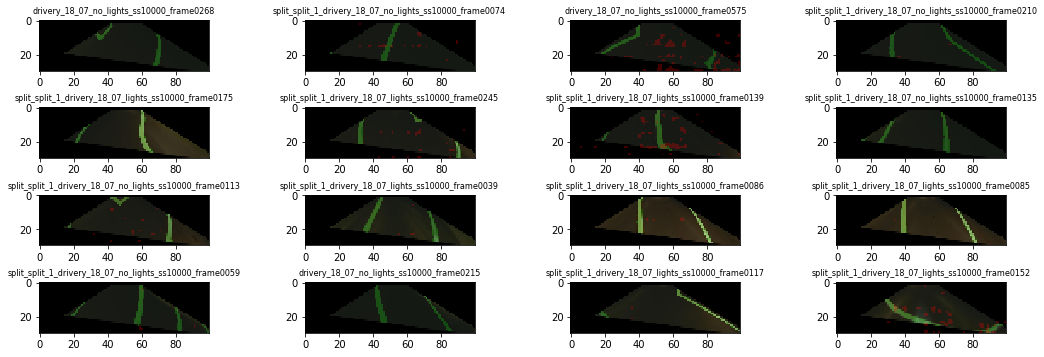

In [27]:
os.makedirs('logs', exist_ok=True)

train_losses = []
train_mious = []
val_losses = []
val_mious = []

for epoch in range(100):
    sess.run(miou_reset)
    
    try:
        batch = 0
        losses = []
        while True:
            _, t_loss, t_miou, _ = sess.run([train_op, loss, train_miou, train_miou_update], 
                                            {dataset_handle: train_handle, is_training: True})
            losses.append(t_loss)
            print('\rEpoch: {}\tBatch: {}\tTrain loss: {:06.4f}\tMiou: {:06.4f}'.format(epoch, batch, np.mean(losses), t_miou), end='')
            batch += 1
    except tf.errors.OutOfRangeError:
        train_losses.append(np.mean(losses))
        train_mious.append(t_miou)
        
        sess.run(validation_iterator.initializer)
        try:
            losses = []
            _, axes = plt.subplots(len(filenames) // 4, 4,
                                  figsize=(15, math.ceil(len(filenames) / 4.)))
            
            for batch in range(len(filenames)):
                v_loss, v_miou, _, img, label, pred = sess.run([loss, val_miou, val_miou_update, input_tensor, labels, predictions], 
                                             {dataset_handle: validation_handle, is_training: False})
                losses.append(v_loss)
                    
                for i in range(img.shape[0]):
                    label_alpha = 0.2
                    pred_alpha = 0.25
                    overlayed = (img[i] + 1.) * 255. / 2.
                    
                    overlayed[label[i] == 1] = (label_alpha * np.array([0, 255, 0]) + (1 - label_alpha) * overlayed[label[i] == 1]).round()
                    overlayed[pred[i] == 1] = (pred_alpha * np.array([255, 0, 0]) + (1 - pred_alpha) * overlayed[pred[i] == 1]).round()
                    overlayed = overlayed.astype(np.uint8)
                    
                    index = batch * img.shape[0] + i
                    axes[index // 4, index % 4].imshow(overlayed)
                    axes[index // 4, index % 4].set_title(filenames[index], fontsize=8)
        except tf.errors.OutOfRangeError:
            val_losses.append(np.mean(losses))
            val_mious.append(v_miou)
            
            plt.tight_layout()
            plt.savefig(os.path.join('logs', 'epoch_{}.jpg'.format(epoch)))
            sess.run(train_iterator.initializer)
            print('\tVal loss: {:06.4f}\tMiou: {:06.4f}'.format(np.mean(losses), v_miou))

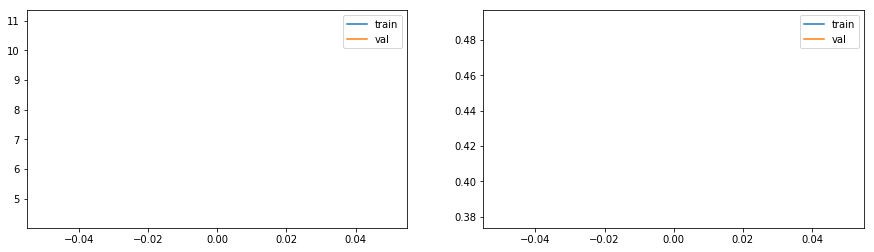

In [31]:
x = np.arange(len(train_losses))

_, axes = plt.subplots(1, 2, figsize=(15, 4))

axes[0].plot(x, train_losses, label='train')
axes[0].plot(x, val_losses, label='val')
axes[0].set_title('Losses')
axes[0].legend()

axes[1].plot(x, train_mious, label='train')
axes[1].plot(x, val_mious, label='val')
axes[1].set_title('Mious')
axes[1].legend()

plt.show()

## Saving the train checkpoint

In [ ]:
to_save = [t for t in tf.all_variables() if ('Conv_1' not in t.name and 'Logits' not in t.name)]
saver = tf.train.Saver(to_save)
saver.save(sess, 'checkpoints/train-checkpoint')

## Convert the train checkpoint to the eval checkpoint for TFLite (the model should have been trained with quantization).

In [ ]:
tf.reset_default_graph()
sess = tf.Session()
input_tensor = tf.placeholder(tf.float32, (1, 256, 640, 3))
net = mobilenet_backbone(input_tensor, 0.35, output_stride=8, weight_decay=0., is_training=False)
net = segmentation_head(input_tensor, net, weight_decay=0., is_training=False, dropout=0)

g = tf.get_default_graph()
tf.contrib.quantize.create_eval_graph(input_graph=g)
to_save = [t for t in tf.all_variables() if 'Conv_1' not in t.name and 'Logits' not in t.name]
saver = tf.train.Saver(var_list=to_save)
saver.restore(sess, 'checkpoints/train-checkpoint')

with open('eval_graph.pb', 'w') as f:
    f.write(str(g.as_graph_def()))
# to_save = [t for t in tf.all_variables() if 'Conv_1' not in t.name and 'Logits' not in t.name]
saver = tf.train.Saver(var_list=to_save)
saver.save(sess, 'checkpoints/eval-checkpoint')